In [0]:
import gensim
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Activation
from keras.models import Model
import sklearn
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
from nltk.tokenize import RegexpTokenizer
from gensim.utils import simple_preprocess
import os

In [0]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
file_csv = pd.read_csv('drive/My Drive/ForGensim/train.csv')

In [0]:
file_csv

,text,intents
0,Add another song to the Cita RomГЎntica playli...,AddToPlaylist
1,add clem burke in my playlist Pre-Party R&B Jams,AddToPlaylist
2,Add Live from Aragon Ballroom to Trapeo,AddToPlaylist
3,add Unite and Win to my night out,AddToPlaylist
4,Add track to my Digster Future Hits,AddToPlaylist
...,...,...
15879,Is Across the Line playing at the closest movi...,SearchScreeningEvent
15880,Which animated movies are playing in the neigh...,SearchScreeningEvent
15881,Where is They Always Return at Dawn playing,SearchScreeningEvent
15882,What is the movie schedule in the neighborhood,SearchScreeningEvent


In [0]:
file_csv = file_csv.dropna()
file_csv['text'].apply(lambda x: len(x.split(' '))).sum()

142821

In [0]:
file_csv['text']

0        Add another song to the Cita RomГЎntica playli...
1         add clem burke in my playlist Pre-Party R&B Jams
2                  Add Live from Aragon Ballroom to Trapeo
3                        add Unite and Win to my night out
4                      Add track to my Digster Future Hits
                               ...                        
15879    Is Across the Line playing at the closest movi...
15880    Which animated movies are playing in the neigh...
15881          Where is They Always Return at Dawn playing
15882       What is the movie schedule in the neighborhood
15883    Tell me when Howling II: Your Sister Is a Were...
Name: text, Length: 15884, dtype: object

In [0]:
intents = file_csv.intents.unique()

In [0]:
COUNT_CLASSES = intents.shape[0]

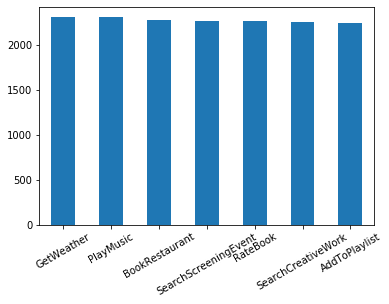

In [0]:
file_csv.intents.value_counts().plot(kind="bar", rot=30)


Удаление стоп-слов и пунктуации

In [0]:
def remove_stopwords(text):
  tokenizer = RegexpTokenizer(r'\w+')
  words = tokenizer.tokenize(text)
  stop_words = set(stopwords.words("english"))
  without_stop_words = [w for w in words if w not in stop_words]
  return without_stop_words

In [0]:
sentences = np.array(file_csv['text'].apply(lambda x : remove_stopwords(x)))

In [134]:
sentences

array([list(['Add', 'another', 'song', 'Cita', 'RomГЎntica', 'playlist']),
       list(['add', 'clem', 'burke', 'playlist', 'Pre', 'Party', 'R', 'B', 'Jams']),
       list(['Add', 'Live', 'Aragon', 'Ballroom', 'Trapeo']), ...,
       list(['Where', 'They', 'Always', 'Return', 'Dawn', 'playing']),
       list(['What', 'movie', 'schedule', 'neighborhood']),
       list(['Tell', 'Howling', 'II', 'Your', 'Sister', 'Is', 'Werewolf', 'playing'])],
      dtype=object)

In [0]:
tokens = []

for sentence in sentences:
  tokens.append(sentence)

In [137]:
tokens[:5]

[['Add', 'another', 'song', 'Cita', 'RomГЎntica', 'playlist'],
 ['add', 'clem', 'burke', 'playlist', 'Pre', 'Party', 'R', 'B', 'Jams'],
 ['Add', 'Live', 'Aragon', 'Ballroom', 'Trapeo'],
 ['add', 'Unite', 'Win', 'night'],
 ['Add', 'track', 'Digster', 'Future', 'Hits']]

Работа с Word2Vec

In [0]:
model = Word2Vec(tokens, size=200, window=10, min_count=3, workers=4)

In [0]:
model.train(tokens, total_examples=len(tokens), epochs=500)

In [100]:
model.most_similar('song')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-12-04 10:30:18,370 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('track', 0.5693663358688354),
 ('music', 0.45309245586395264),
 ('songs', 0.44030633568763733),
 ('anything', 0.4304860830307007),
 ('88', 0.4297087788581848),
 ('ep', 0.4238709509372711),
 ('tune', 0.42381590604782104),
 ('artist', 0.41762661933898926),
 ('chopin', 0.4151551127433777),
 ('Taylor', 0.3999366760253906)]

In [101]:
model.most_similar(positive=['song'], negative=['artist'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('soundtrack', 0.3645138144493103),
 ('painting', 0.35434088110923767),
 ('trailer', 0.345719575881958),
 ('Jeremy', 0.3122348487377167),
 ('television', 0.3080294132232666),
 ('game', 0.30089908838272095),
 ('Jim', 0.2965252995491028),
 ('TV', 0.2940673232078552),
 ('Taylor', 0.29297173023223877),
 ('picture', 0.29182523488998413)]

In [0]:
def transform_from_categorical(prediction):
  answers = []

  for elem in prediction:
    if elem == 0:
      answers.append('PlayMusic')
    elif elem == 1:
      answers.append('GetWeather')
    elif elem == 2:
      answers.append('BookRestaurant')
    elif elem == 3:
      answers.append('SearchScreeningEvent')
    elif elem == 4:
      answers.append('RateBook')
    elif elem == 5:
      answers.append('SearchCreativeWork')
    elif elem == 6:
      answers.append('AddToPlaylist')

  return answers

In [0]:
def transform_to_categorical(y):
  intents_for_each_ = y
  intents_to_digit = []

  for intent in intents_for_each_:
    if intent == 'PlayMusic':
      intents_to_digit.append(0)
    elif intent == 'GetWeather':
      intents_to_digit.append(1)
    elif intent == 'BookRestaurant':
      intents_to_digit.append(2)
    elif intent == 'SearchScreeningEvent':
      intents_to_digit.append(3)
    elif intent == 'RateBook':
      intents_to_digit.append(4)
    elif intent == 'SearchCreativeWork':
      intents_to_digit.append(5)
    elif intent == 'AddToPlaylist':
      intents_to_digit.append(6)

  return to_categorical(intents_to_digit, COUNT_CLASSES)

Работа с keras

In [0]:
# Создание модели
def get_model(model):
    kmodel = Sequential() 
    kmodel.add(model.wv.get_keras_embedding(train_embeddings=True))
    
    kmodel.add(Dropout(0.2))

    kmodel.add(Conv1D(50,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
    kmodel.add(GlobalMaxPooling1D())

    kmodel.add(Dense(250))
    kmodel.add(Dropout(0.2))
    kmodel.add(Activation('relu'))

    kmodel.add(Dense(7, activation = 'softmax'))

    kmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
    return kmodel

In [0]:
word_vectors = model.wv

In [106]:
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 3629


In [0]:
texts = sentences

In [108]:
texts

array([list(['Add', 'another', 'song', 'Cita', 'RomГЎntica', 'playlist']),
       list(['add', 'clem', 'burke', 'playlist', 'Pre', 'Party', 'R', 'B', 'Jams']),
       list(['Add', 'Live', 'Aragon', 'Ballroom', 'Trapeo']), ...,
       list(['Where', 'They', 'Always', 'Return', 'Dawn', 'playing']),
       list(['What', 'movie', 'schedule', 'neighborhood']),
       list(['Tell', 'Howling', 'II', 'Your', 'Sister', 'Is', 'Werewolf', 'playing'])],
      dtype=object)

In [0]:
vocab_size = len(word_vectors.vocab)
token = Tokenizer(vocab_size)
token.fit_on_texts(texts)
text = token.texts_to_sequences(texts)
text = pad_sequences(text, maxlen=10)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(text, file_csv['intents'], test_size=0.2, stratify=file_csv['intents'])

In [0]:
y_train = transform_to_categorical(y_train)

In [0]:
y_test =  transform_to_categorical(y_test)

In [113]:
my_model = get_model(model)
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         725800    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 50)          30050     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               12750     
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 250)              

In [129]:
my_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Train on 12707 samples, validate on 3177 samples
Epoch 1/10
12707/12707 [==============================] - 3s 270us/step - loss: 0.0228 - acc: 0.9929 - val_loss: 0.1240 - val_acc: 0.9751
Epoch 2/10
12707/12707 [==============================] - 3s 269us/step - loss: 0.0228 - acc: 0.9913 - val_loss: 0.1214 - val_acc: 0.9754
Epoch 3/10
12707/12707 [==============================] - 3s 273us/step - loss: 0.0285 - acc: 0.9909 - val_loss: 0.1100 - val_acc: 0.9751
Epoch 4/10
12707/12707 [==============================] - 3s 275us/step - loss: 0.0246 - acc: 0.9926 - val_loss: 0.1511 - val_acc: 0.9714
Epoch 5/10
12707/12707 [==============================] - 3s 273us/step - loss: 0.0183 - acc: 0.9943 - val_loss: 0.1272 - val_acc: 0.9767
Epoch 6/10
12707/12707 [==============================] - 3s 273us/step - loss: 0.0111 - acc: 0.9965 - val_loss: 0.1251 - val_acc: 0.9780
Epoch 7/10
12707/12707 [==============================] - 3s 263us/step - loss: 0.0174 - acc: 0.9944 - val_loss: 0.1138 - v

In [0]:
X_predict = []
X_predict.append([ 222,    10,   0,  361,    3, 1924,   19,  559,    1, 1886])# не знаем, как строку преобразовать в вектор чисел
X_predict = np.array(X_predict)

In [0]:
prediction = my_model.predict_classes(X_predict)

In [132]:
answers = transform_from_categorical(prediction)
answers

['BookRestaurant']